In [28]:
import requests
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt


In [31]:
# Reading CSV file as a DataFrame
violations = pd.read_csv('../../Data/Food_Inspections.csv')

# Taking a look at a snapshot of the data
violations.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2563767,CERES' TABLE,CERES' TABLE,2137239.0,Restaurant,Risk 1 (High),3124 N BROADWAY,CHICAGO,IL,60657.0,09/15/2022,Non-Inspection,No Entry,NaN,41.938412,-87.644492,"(41.93841197166044, -87.64449180403412)"
1,2563480,FINKI ELEMENTARY ACADEMY,FINKI ELEMENTARY ACADEMY,23541.0,School,Risk 1 (High),2332 S Western (2400W),CHICAGO,IL,60608.0,09/12/2022,Canvass,Pass,NaN,NaN,NaN,NaN
2,2563279,SH GRILL,SH GRILL,2863054.0,Catering,Risk 1 (High),167 N GREEN ST,CHICAGO,IL,60607.0,09/06/2022,License,Pass,NaN,41.885044,-87.648476,"(41.88504417665877, -87.64847590715003)"


In [3]:
# Checking the shape of the dataframe
violations.shape

(251211, 17)

#### 1. Select only the records corresponding to failed inspection (see "Results" column)

In [4]:
# Looking at the composition of Results
violations.Results.value_counts()

Pass                    129441
Fail                     48794
Pass w/ Conditions       38663
Out of Business          21485
No Entry                  9697
Not Ready                 3050
Business Not Located        81
Name: Results, dtype: int64

In [5]:
# Selecting only records with Results = Fail
fail_inspections = violations[violations['Results'] == 'Fail']
print("No. of Failed inspections : {0}".format(fail_inspections.shape[0]))

No. of Failed inspections : 48794


#### 2. Clean the data, making sure that there are no NaNs in "Violations" column

In [6]:
# Checking number of missing Violations
fail_inspections.Violations.isnull().sum()

3359

In [7]:
# Cleaning the data by dropping entries with missing Violations
fail_inspections = fail_inspections[fail_inspections['Violations'].notna()]
fail_inspections.Violations.isnull().sum()

0

In [8]:
fail_inspections.shape

(45435, 17)

#### 3. "Violations" column lists the reasons for inspection failure. Those reasons are separated by "|".  Each reason consists of a regulation code, regulation description, and comments describing how the regulation was violated. 

In [9]:
# Viewing sample Violation
fail_inspections.Violations.iloc[1095]

"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: OBSERVED NO CITY OF CHICAGO CERTIFIED FOOD MANAGER ON SITE WITH THE ORIGINAL CITY OF CHICAGO FOOD SERVICE MANAGER CERTIFICATE, WHILE THE TIME/TEMPERATURE CONTROL FOR SAFETY FOODS (MEAT LOAF) HAS BEEN RECEIVED AND SERVED. INSTRUCTED A CITY OF CHICAGO CERTIFIED FOOD MANAGER MUST BE ON SITE AT ALL TIMES WHILE FOODS ARE BEING REIEVED, PREPARED AND SERVED. PRIORITY FOUNDATION VIOLATION 7-38-012,CITATION ISSUED | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED NO HOT RUNNING WATER AT EMPLOYEE TOILET ROOM HANDWASHING SINK. TEMPERATURE OF WATER WAS 42.3F AT THE TIME OF INSPECTION. INSTRUCTED TO HAVE HOT AND COLD RUNNING AT ALL HAND WASH SINKS.  PRIORITY VIOLATION  7-38-030(C), CITATION ISSUED | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: OBSERVED APPROXIMATELY 38 MICE DROPPINGS ON SITE IN THE FOLLOWING AREAS: IN THE FURNACE CLOSET IN THE BASEMENT AND ON THE FLOOR, UNDER THE DRAI

#### 4. Using regular expression, parse "Violations" column to select only regulation descriptions, no code or comments

In [10]:
# Extracting only regulation descriptions from the 'Violations' column
reg_descriptions = []
for violation in fail_inspections['Violations']:
    # Using regular expression to find only the regulation descriptions
    reg_exp = r'(?<=(?<=\|\s|^)\d{1,2}\.\s)([A-Z\s()\-0-9\*&,;/:.\']+)(?=(?= - Comments:|\s\||$))'
    matches = re.findall(reg_exp, violation)
    reg_descriptions.append(matches)

# Adding extracted regulation descriptions as a new column in the DataFrame
fail_inspections.loc[:,'Regulation_Desc'] = reg_descriptions

In [11]:
# Viewing sample extracted regulation description
fail_inspections.Regulation_Desc.iloc[1095]

['CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE',
 'ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
 'INSECTS, RODENTS, & ANIMALS NOT PRESENT',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN']

In [12]:
# Testing if we have extracted the descriptions correctly from the Violations
fail_inspections['Desc COUNT'] = fail_inspections['Violations'].str.count('\|')+1
fail_inspections['Violation COUNT'] = fail_inspections['Regulation_Desc'].str.len()
fail_inspections['test'] = np.where(fail_inspections['Desc COUNT']==fail_inspections['Violation COUNT'], 0, 1)
sum(fail_inspections['test'])

0

#### 5. Count how many times each regulation description occurred in the table and visualize top-10 the most frequent regulation descriptions

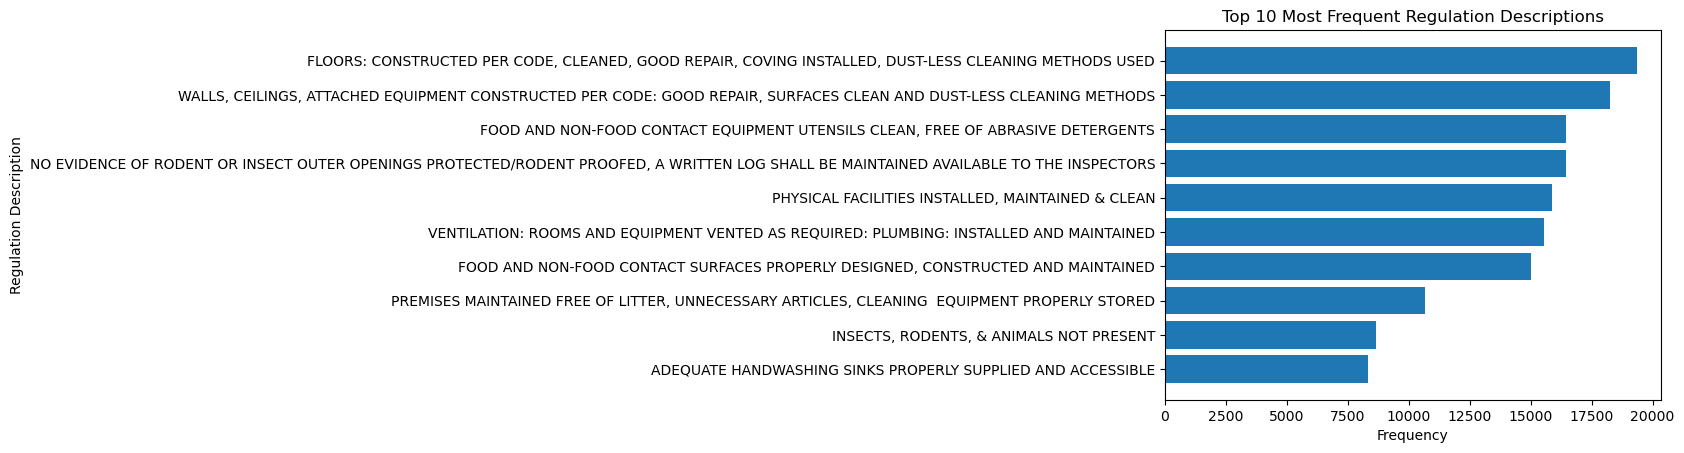

In [13]:
top_10_reg = fail_inspections.Regulation_Desc.explode().dropna().value_counts().head(10)

# Creating a bar plot of the top 10 most frequent regulation descriptions
plt.barh(top_10_reg.index, top_10_reg.values)
plt.gca().invert_yaxis()
plt.title('Top 10 Most Frequent Regulation Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Regulation Description')
plt.show()

#### 6. Identify whether any of these restaurants are repeat offenders (explore a combination of License; Business Name and Address variables to determine what is the best way to uniquely identify a business) and whether the violations are the same or different for these repeat offenses

In [14]:
rest_df = fail_inspections[['License #', 'DBA Name', 'Address','Inspection ID','Regulation_Desc']].reset_index(drop=True).copy()
# Making all columns uppercase in order to avoid duplicates caused by case mismatch
rest_df = rest_df.applymap(lambda x: x.upper() if isinstance(x, str) else x)

# Filling NAs in order to avoid losing data on aggregation
rest_df['License #'] = rest_df['License #'].fillna(0.0)

# Converting the list column into a set column and then back into a list column to drop any duplicates
rest_df['Regulation_Desc'] = rest_df['Regulation_Desc'].apply(lambda x: list(set(x)))

# Grouping by restaurant and count the number of unique inspections for each business and their corresponding violations
grouped_df = rest_df.groupby(['License #', 'DBA Name', 'Address']).agg({'Inspection ID': pd.Series.nunique, 'Regulation_Desc': lambda x: x.tolist(),}).reset_index()
grouped_df.columns = ['License #', 'DBA Name', 'Address', '# Failed Inspections', 'Violations']

# Filtering the number of failed inspections to identify repeat offenders
df_repeat = grouped_df[grouped_df['# Failed Inspections'] > 1].reset_index(drop=True)

print("Of the {0} restaurants that have failed inspections, {1} restaurants are repeat offenders".format(str(grouped_df.shape[0]), str(df_repeat.shape[0])))


Of the 21048 restaurants that have failed inspections, 10289 restaurants are repeat offenders


In [15]:
# Tracking a sample to ensure our code works right
df_repeat['Violations'].iloc[9]

[['FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
  'FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
  'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED'],
 ['WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
  'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED',
  'FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
  'ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, PROPERLY DESIGNED AND INSTALLED',
  'FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
  'NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS']]

In [16]:
# Flattening the column using apply() method and lambda function
df_repeat['Violations'] = df_repeat['Violations'].apply(lambda x: [item for sublist in x for item in sublist])
df_repeat['Violations'].iloc[9]

['FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
 'FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
 'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED',
 'WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
 'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED',
 'FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
 'ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, PROPERLY DESIGNED AND INSTALLED',
 'FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
 'NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS']

In [17]:
# Creating new column with True if list of Violations has duplicates, False otherwise
df_repeat['Repeat Violations'] = df_repeat['Violations'].apply(lambda x: len(x) != len(set(x)))

# Filtering out the repeat offenders
repeat_offenders = df_repeat[df_repeat['Repeat Violations'] == True]

# Testing
df_repeat['Repeat Violations'].iloc[1675]

True

In [18]:
print("Of the {1} repeat offender restaurants, {0} restaurants have the same violation in their repeat offenses".format(str(repeat_offenders.shape[0]), str(df_repeat.shape[0])))


Of the 10289 repeat offender restaurants, 8801 restaurants have the same violation in their repeat offenses


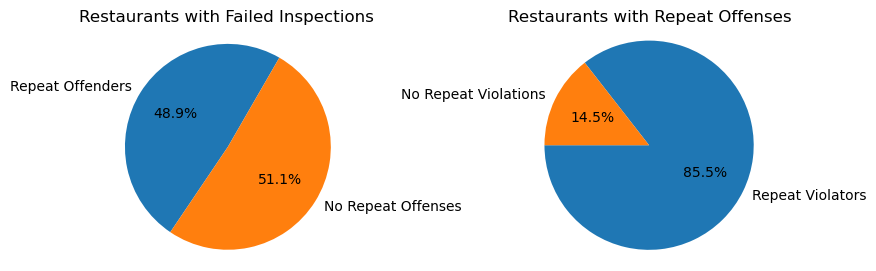

In [19]:
# Repeat Offenders are restaurants that have failed inspections more than once
plot1 = {'Repeat Offenders' : df_repeat.shape[0], 'No Repeat Offenses' : grouped_df.shape[0] - df_repeat.shape[0]}
# Repeat Violators are repeat offenders who have failed more than one inspection due to the same violation
plot2 = {'Repeat Violators' : repeat_offenders.shape[0], 'No Repeat Violations' : df_repeat.shape[0] - repeat_offenders.shape[0]}

# Extracting keys and values into separate lists
labels1 = list(plot1.keys())
sizes1 = list(plot1.values())

labels2 = list(plot2.keys())
sizes2 = list(plot2.values())

# Creating the pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=60)
ax1.axis('equal')
ax1.set_title('Restaurants with Failed Inspections')

ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=180)
ax2.axis('equal')
ax2.set_title('Restaurants with Repeat Offenses')

# Displaying the plot
plt.show()

##### About 50% of the businesses are repeat offenders and ~85.5% of these repeat offenders have repeats of the same violations.

#### 7. Review the restaurants "Out of Business", is there an extended history of prior violations for these closed businesses?

In [20]:
# Selecting only records with Results = Out of Business
oob = violations[violations['Results'] == 'Out of Business'].copy()
oob = oob[['License #', 'DBA Name', 'Address']].reset_index(drop=True).copy()

# Filling NAs in order to avoid losing data on aggregation and converting to uppercase
oob['License #'] = oob['License #'].fillna(0.0)
oob = oob.applymap(lambda x: x.upper() if isinstance(x, str) else x)

# Finding only the distinct restaurants that went Out of Business
oob = oob.drop_duplicates()

print("{0} establishments went Out of Business.".format(oob.shape[0]))

20980 establishments went Out of Business.


In [21]:
# Checking back with the original data to see if these 20980 businesses had inspections with violations
prior_data = violations[violations['Results'] != 'Out of Business'].copy()
prior_data = prior_data.applymap(lambda x: x.upper() if isinstance(x, str) else x)

# Merging to retain only our OOB businesses in the OG data
history_violation = pd.merge(oob, prior_data, on=['License #', 'DBA Name', 'Address'], how = 'inner')
history_violation = history_violation[['License #', 'DBA Name', 'Address', 'Violations']].reset_index(drop=True).copy()

# Selecting entries with prior history of violations for the OOB instances
history_violation = history_violation[history_violation['Violations'].notna()]
history_violation = history_violation.groupby(['License #', 'DBA Name', 'Address'])['Violations'].count().reset_index()

print('{0} of the {1} closed businesses had a history of prior violations.'.format(history_violation.shape[0], oob.shape[0]))

14967 of the 20980 closed businesses had a history of prior violations.


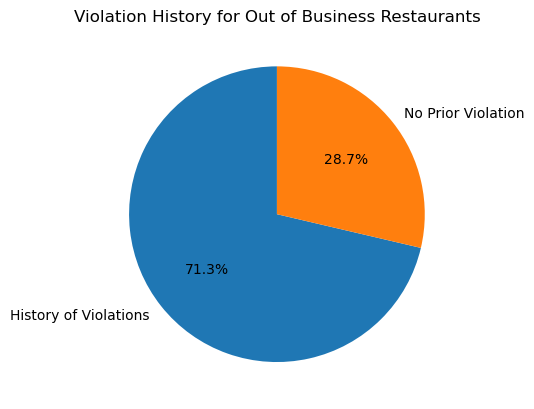

In [22]:
oob_violations = {'History of Violations' : history_violation.shape[0], 'No Prior Violation' : oob.shape[0] - history_violation.shape[0]}

# Extracting keys and values into separate lists
labels = list(oob_violations.keys())
sizes = list(oob_violations.values())

# Creating a pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Violation History for Out of Business Restaurants')

# Displaying the plot
plt.show()


##### Since about 70% of restaurants that went out of business had a history of Violations, we can assume that it is more likely for restaurants with violations to go out of business. 

#### 8. Food inspection data has 10+ years of history, do you see any changing trends in most common violations?  Plot the results for top-5 most frequent violations over time

In [23]:
# Taking a look at Top 5 Violations from Q5
top_5_violations = fail_inspections.Regulation_Desc.explode().dropna().value_counts().head(5).index.tolist()
top_5_violations

['FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED',
 'WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
 'FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
 'NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN']

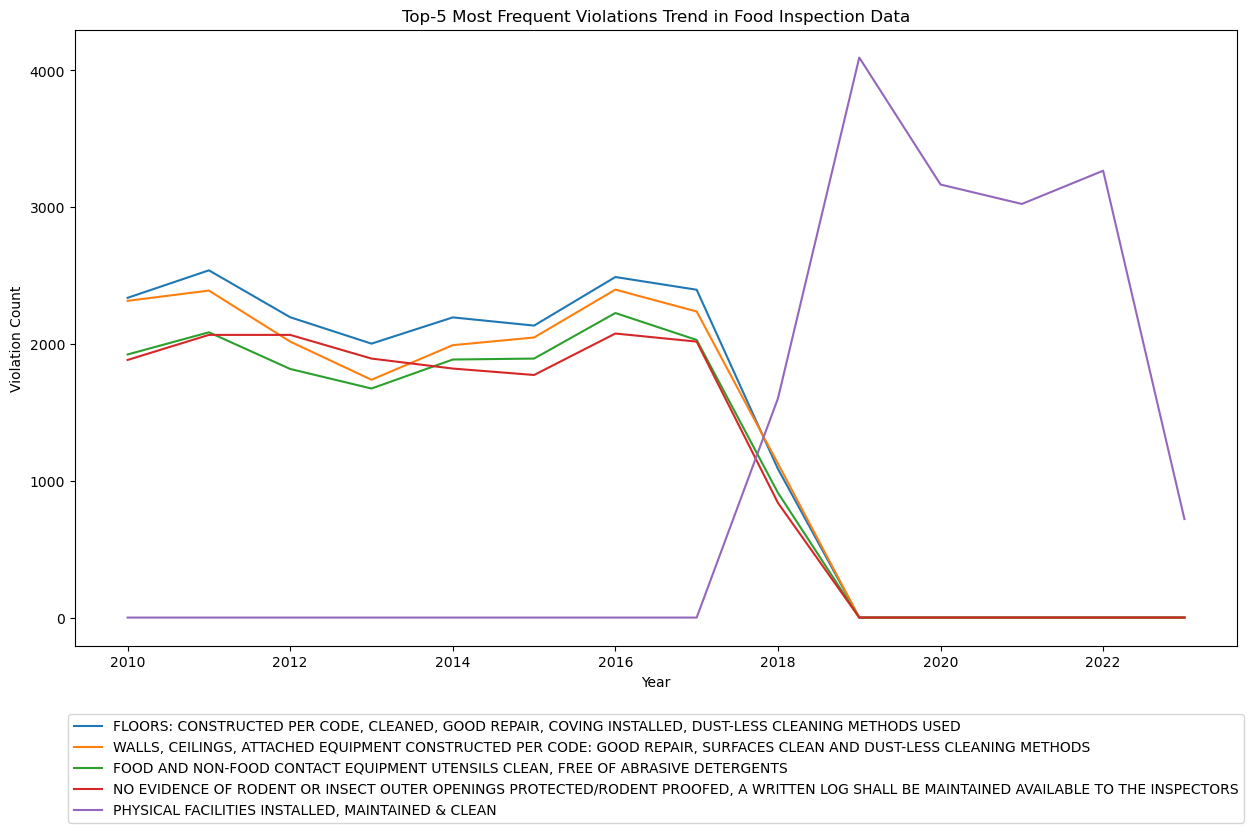

In [27]:
# Extracting year from inspection date
fail_inspections['Inspection Year'] = fail_inspections['Inspection Date'].str[-4:].astype(int)
violation_trend = fail_inspections[['Inspection Year', 'Regulation_Desc']]

# Exploding the Regulation_Desc column
violation_trend = violation_trend.explode('Regulation_Desc')

# Filtering the Regulation_Desc column for the top 5 violations
violation_trend = violation_trend[violation_trend['Regulation_Desc'].isin(top_5_violations)]

# Counting the violations by year 
violation_trend = violation_trend.groupby(['Inspection Year', 'Regulation_Desc']).agg(Count=('Regulation_Desc', 'count')).reset_index()
violation_trend = violation_trend.sort_values(by=['Inspection Year','Regulation_Desc'], ascending= True).reset_index(drop=True)

# Pivoting the data by year and regulation, with the count as the values
df_pivot = violation_trend.pivot(index='Inspection Year', columns='Regulation_Desc', values='Count').fillna(0)
# Reorder in the order of Top 5
df_pivot = df_pivot.loc[:, top_5_violations]

# Plotting the trend chart
fig, ax = plt.subplots(figsize=(15, 8))
df_pivot.plot(kind='line', ax=ax)

ax.set_title('Top-5 Most Frequent Violations Trend in Food Inspection Data')
ax.set_xlabel('Year')
ax.set_ylabel('Violation Count')

# Move the legend to the bottom of the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()


##### We can observe that the overall top 4 violations did not occur post 2018 and similarly the 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN' violation only occurs in our data starting 2018. This could possibly be due to the updation of Inspection standards and Violation codes over time